Random Forest Regressor - R2 Score: 0.9963515399710885
Random Forest Regressor - RMSE: 0.5615512926450782
Random Forest Regressor - MAE: 0.3217839195979895
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Evaluation Results for Random Forest model with tuning:
R2 Score: 0.9876156818842541
RMSE: 1.0345957369400243
MAE: 0.752777889447237
Predictions for the next 200 days saved to ../../../models/RandomForestRegressor/results/future_tempmax_predictions_200_days.csv


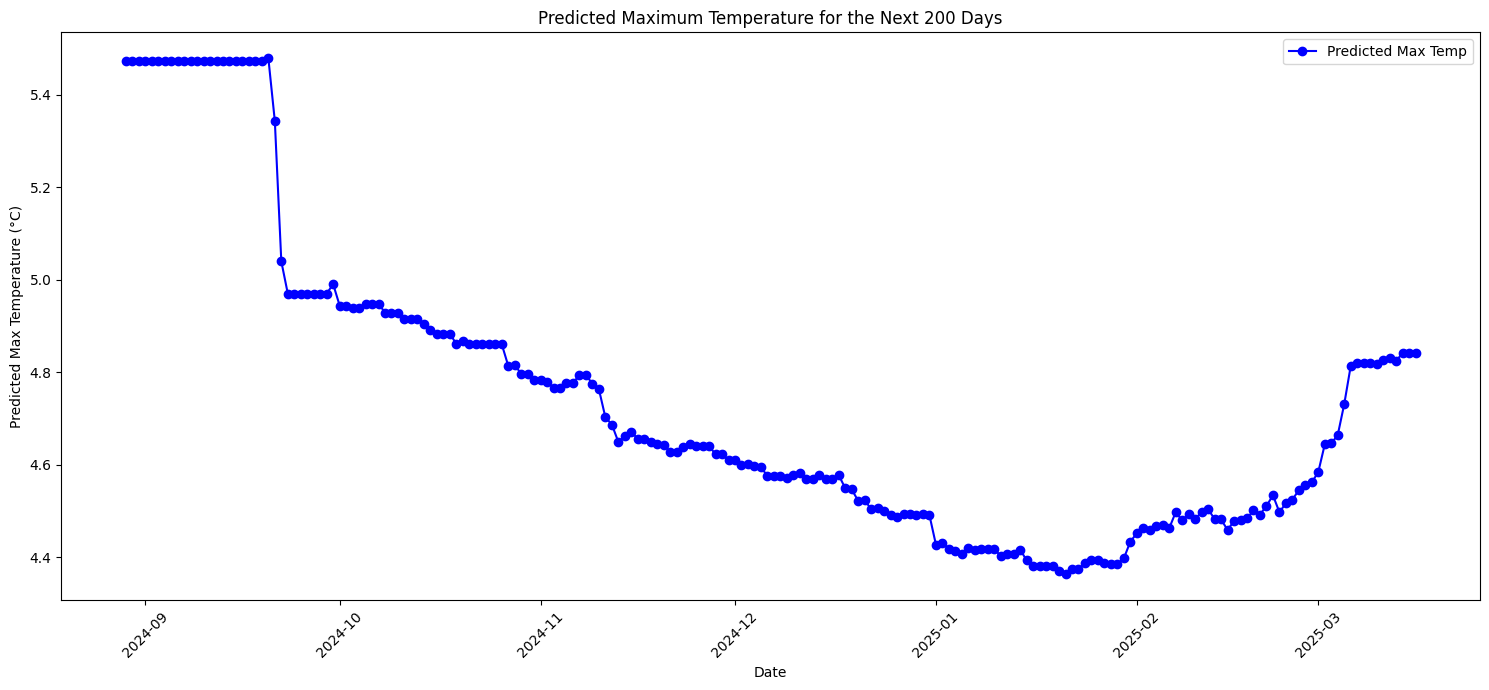

Random Forest Regressor model processing complete.


In [1]:
# Filename: C:/Users/ADMIN/AI_asm2/models/RandomForestRegressor/scripts/testRandomForestRegressor.ipynb

# In[0]: IMPORT AND FUNCTIONS
#region 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import os
import pickle
#endregion

# Ensure the necessary directories exist
base_dir = "../../../models/RandomForestRegressor"
os.makedirs(f"{base_dir}/preprocessing", exist_ok=True)
os.makedirs(f"{base_dir}/results", exist_ok=True)
os.makedirs(f"{base_dir}/figures", exist_ok=True)

# In[1]: STEP 2. GET THE DATA
file_path = "../../../data/NewYork.csv"
data = pd.read_csv(file_path)

# In[2]: HANDLE DATETIME
data['datetime'] = pd.to_datetime(data['datetime'])
data['day_of_year'] = data['datetime'].apply(lambda x: x.timetuple().tm_yday)
data['month'] = data['datetime'].dt.month
data['hour'] = data['datetime'].dt.hour
data['year'] = data['datetime'].dt.year

# In[3]: DROP UNNECESSARY COLUMNS
columns_to_drop = ['name', 'stations', 'icon', 'description', 'sunrise', 'sunset', 'preciptype', 'snow', 'conditions']
data = data.drop(columns=columns_to_drop)

# In[4]: HANDLE MISSING VALUES
numeric_cols = data.select_dtypes(include=[np.number]).columns
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())

# In[5]: FEATURE ENGINEERING
# Reassess the features - Ensure alignment and relevance
data['tempmax_lag1'] = data['tempmax'].shift(1)
data['tempmax_lag3'] = data['tempmax'].shift(3)
data['humidity_lag1'] = data['humidity'].shift(1)
data['tempmax_rolling_mean_3'] = data['tempmax'].rolling(window=3).mean()
data['tempmax_rolling_std_3'] = data['tempmax'].rolling(window=3).std()
data['precip_rolling_sum_7'] = data['precip'].rolling(window=7).sum()

# Ensure features are aligned with temperature trends
data['day_of_year_cos'] = np.cos(2 * np.pi * data['day_of_year'] / 365)
data['day_of_year_sin'] = np.sin(2 * np.pi * data['day_of_year'] / 365)

# Interaction feature
data['temp_precip_interaction'] = data['temp'] * data['precip']

# Drop rows with NaN values generated by shifting
data = data.dropna()

# In[6]: PREPARE DATA FOR RANDOM FOREST
X = data.drop(columns=['tempmax', 'datetime'])
y = data['tempmax']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the scaler
scaler_path = f"{base_dir}/preprocessing/scaler.pkl"
with open(scaler_path, 'wb') as file:
    pickle.dump(scaler, file)

# In[7]: TRAIN THE RANDOM FOREST REGRESSOR MODEL
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test_scaled)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

# Save evaluation metrics
with open(f"{base_dir}/results/model_evaluation.txt", "w") as file:
    file.write(f"R2 Score: {r2}\n")
    file.write(f"RMSE: {rmse}\n")
    file.write(f"MAE: {mae}\n")

print(f"Random Forest Regressor - R2 Score: {r2}")
print(f"Random Forest Regressor - RMSE: {rmse}")
print(f"Random Forest Regressor - MAE: {mae}")

# In[8]: HYPERPARAMETER TUNING
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_grid,
    n_iter=100,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_scaled, y_train)

# Save the best model after tuning
best_rf_model = random_search.best_estimator_

model_with_tuning_path = f"{base_dir}/models/random_forest_model_with_tuning.pkl"
os.makedirs(os.path.dirname(model_with_tuning_path), exist_ok=True)
with open(model_with_tuning_path, 'wb') as file:
    pickle.dump(best_rf_model, file)

# Evaluate the tuned model
y_pred_tuned = best_rf_model.predict(X_test_scaled)

r2_tuned = r2_score(y_test, y_pred_tuned)
rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)

# Save evaluation metrics after tuning
with open(f"{base_dir}/results/model_evaluation_with_tuning.txt", "w") as file:
    file.write(f"R2 Score: {r2_tuned}\n")
    file.write(f"RMSE: {rmse_tuned}\n")
    file.write(f"MAE: {mae_tuned}\n")

print(f"Evaluation Results for Random Forest model with tuning:")
print(f"R2 Score: {r2_tuned}")
print(f"RMSE: {rmse_tuned}")
print(f"MAE: {mae_tuned}")

# In[9]: FUTURE PREDICTIONS
# Reload the original data for creating future predictions
original_data = pd.read_csv(file_path)
original_data['datetime'] = pd.to_datetime(original_data['datetime'])
original_data['day_of_year'] = original_data['datetime'].dt.dayofyear

# Generate future dates
future_days = 200
start_date = pd.to_datetime('today').normalize()
future_dates = pd.date_range(start=start_date, periods=future_days, freq='D')

# Create base DataFrame for future predictions
future_data = pd.DataFrame({'datetime': future_dates})
future_data['day_of_year'] = future_data['datetime'].dt.dayofyear
future_data['day_of_year_cos'] = np.cos(2 * np.pi * future_data['day_of_year'] / 365)
future_data['day_of_year_sin'] = np.sin(2 * np.pi * future_data['day_of_year'] / 365)

# Ensure future_data has all the features used in training and remove 'datetime'
required_columns = X.columns  # Get the columns from the training data

for col in required_columns:
    if col not in future_data.columns:
        future_data[col] = 0  # Fill missing columns with zero or another appropriate value

# Drop the 'datetime' column as it was not used in training
if 'datetime' in future_data.columns:
    future_data = future_data.drop(columns=['datetime'])

# Ensure the order of columns matches the training data
future_data = future_data[required_columns]

# Scale the future data
future_data_scaled = scaler.transform(future_data)

# Predict with the trained model
future_tempmax_predictions = best_rf_model.predict(future_data_scaled)

# Compile predictions
predictions_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Max_Temp': future_tempmax_predictions.flatten()
})

# Save predictions
predictions_df.to_csv(f"{base_dir}/results/future_tempmax_predictions_200_days.csv", index=False)
print("Predictions for the next 200 days saved to ../../../models/RandomForestRegressor/results/future_tempmax_predictions_200_days.csv")

# Visualization: Plot predictions
plt.figure(figsize=(15, 7))
plt.plot(predictions_df['Date'], predictions_df['Predicted_Max_Temp'], label='Predicted Max Temp', color='blue', marker='o')
plt.title('Predicted Maximum Temperature for the Next 200 Days')
plt.xlabel('Date')
plt.ylabel('Predicted Max Temperature (°C)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig(f"{base_dir}/figures/future_tempmax_predictions.png")
plt.show()

print("Random Forest Regressor model processing complete.")
